In [1]:
from pathlib import Path
import pickle
import pandas as pd
from ForecastEvaluator import ForecastEvaluator
from _config import PKL_PROCESSED_STEP1_DTU_SOLAR_STATION
from data_loader import MyDataLoader
from my_config import MyConfig, load_config

class ResultInstance:
    absolute_path: Path
    config: MyConfig
    df: pd.DataFrame
    metrics:dict[str, float]

    def __init__(self, absolute_path: Path):
        self.absolute_path = absolute_path
        self.config = load_config(absolute_path.parent / "config.json")
        with open(absolute_path, "rb") as f:
            self.df = pickle.load(f)

class Results:
    results = list[ResultInstance]
    truth: pd.DataFrame
    overlapping_indexes: list

    def __init__(self):
        self.results = []
        self.truth = pd.DataFrame()

    def load_truth(self, target_column: str):
        df = pd.read_pickle(PKL_PROCESSED_STEP1_DTU_SOLAR_STATION)
        df = df[target_column].to_frame()
        self.overlapping_indexes = list(set(df.index)) # Initialize with all indexes from the truth data
        self.truth = df.copy()
        del df


    def match_indexes(self):
        """
        Matches the indexes of all results with the truth data.
        This ensures that all results only contain the indexes that are present in all results.
        """
        overlapping_indexes = set.intersection(*[set(x.df.index) for x in self.results])
        overlapping_indexes = set.intersection(overlapping_indexes, set(self.truth.index))
        overlapping_indexes = list(overlapping_indexes)
        self.overlapping_indexes = overlapping_indexes

        for result in self.results:
            result.df = result.df.loc[overlapping_indexes]
            result.df.sort_index(inplace=True)
        
        self.truth = self.truth.loc[overlapping_indexes]
        self.truth.sort_index(inplace=True)

PATH_BASE = Path(r'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting')

results = Results()
TARGET = "DNI"
results.load_truth(TARGET)

In [2]:
for file in (PATH_BASE / 'checkpoint').rglob('predictions.pkl'):
    print(f"Loading {file}")
    results.results.append(ResultInstance(file))

for result in results.results:
    print(f"Loaded {result.absolute_path.parent.name} with {len(result.df.index)} rows")


Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250602-092302_DNI_STATION_1_32\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250602-172507_DNI_STATION_ECMWF_1_32\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250603-094013_DNI_STATION_ECMWF_2_128\predictions.pkl
Loading D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250603-145436\predictions.pkl
Loaded 20250602-092302_DNI_STATION_1_32 with 469504 rows
Loaded 20250602-172507_DNI_STATION_ECMWF_1_32 with 222720 rows
Loaded 20250603-094013_DNI_STATION_ECMWF_2_128 with 222720 rows
Loaded 20250603-145436 with 222976 rows


In [3]:
results.match_indexes()

In [4]:
with open(PATH_BASE / 'OLS_performance_predictions_df.pkl', "rb") as f:
    model_ols_df = pickle.load(f)

OLS_PRED_COLUMN = '59'
overlapping_indexes = list(set.intersection(set(model_ols_df.index), set(results.overlapping_indexes)))
print(model_ols_df.shape)
model_ols_df = model_ols_df.loc[overlapping_indexes]
model_ols_df.sort_index(inplace=True)
print(model_ols_df.shape)

(244869, 1)
(222720, 1)


In [5]:
display(model_ols_df.head(), results.truth.head())

,59
2024-01-01 07:43:00,0.003187
2024-01-01 07:44:00,0.001952
2024-01-01 07:45:00,0.003910
2024-01-01 07:46:00,0.004253
2024-01-01 07:47:00,0.006069


,DNI
2024-01-01 07:43:00,0.0
2024-01-01 07:44:00,0.0
2024-01-01 07:45:00,0.0
2024-01-01 07:46:00,0.0
2024-01-01 07:47:00,0.0


In [6]:
comparison_df = pd.DataFrame(index=results.truth.index)
comparison_df[TARGET] = results.truth[TARGET]
comparison_df['OLS'] = model_ols_df[OLS_PRED_COLUMN]
comparison_df

,DNI,OLS
2024-01-01 07:43:00,0.000,0.003187
2024-01-01 07:44:00,0.000,0.001952
2024-01-01 07:45:00,0.000,0.003910
2024-01-01 07:46:00,0.000,0.004253
2024-01-01 07:47:00,0.000,0.006069
...,...,...
2024-12-29 12:20:00,0.036,0.071777
2024-12-29 12:21:00,0.026,0.082820
2024-12-29 12:22:00,0.019,0.077299
2024-12-29 12:23:00,0.018,0.067636


In [7]:
results.results[0].df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,115.786493,83.078241,62.783825,48.974341,39.421726,33.604370,27.077382,22.086504,19.144407,15.630067,...,4.461317,5.902766,6.868482,8.238275,7.867630,6.907569,6.910061,6.895485,7.289761,6.922384
2024-01-01 07:44:00,114.962208,84.498236,64.303434,49.933447,41.197239,32.716159,26.206909,22.365069,18.187017,16.126344,...,5.903453,6.868914,8.238723,7.867973,6.907718,6.910210,6.895634,7.289836,6.922384,6.767988
2024-01-01 07:45:00,117.422462,86.202109,65.576382,52.725295,40.346847,31.680981,26.501886,21.430609,18.706016,15.759294,...,6.869347,8.238961,7.868212,6.907972,6.910314,6.895738,7.289985,6.922533,6.768137,8.989054
2024-01-01 07:46:00,118.225091,86.560312,67.716460,50.794350,38.979754,31.820518,25.376404,21.796570,18.203771,16.013721,...,8.239558,7.868615,6.908434,6.910568,6.896067,7.290284,6.922727,6.768316,8.989173,8.337904
2024-01-01 07:47:00,118.717676,88.457414,65.558390,48.737593,39.009666,30.503089,25.693893,21.243362,18.422019,16.032683,...,7.869092,6.908778,6.910896,6.896365,7.290448,6.922876,6.768465,8.989292,8.338083,7.005019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-29 12:20:00,136.866075,116.967547,100.413336,84.147135,73.420843,65.639832,61.303251,57.726789,54.317492,50.306315,...,34.341662,32.128071,29.722010,31.629347,29.963130,27.473986,29.524947,32.745221,34.229964,29.193121
2024-12-29 12:21:00,140.922299,115.617223,96.010762,82.927083,73.383993,67.671950,63.014501,58.735575,54.010819,45.920950,...,32.131174,29.724562,31.631435,29.964816,27.475553,29.526096,32.746280,34.230889,29.193896,27.178159
2024-12-29 12:22:00,135.559552,110.537786,94.277604,82.477061,75.060161,69.094981,63.783242,58.220298,49.446069,47.301709,...,29.727605,31.634031,29.966934,27.477298,29.527587,32.747414,34.231904,29.194702,27.178890,28.805214
2024-12-29 12:23:00,131.267982,109.704311,94.548695,84.723631,76.969474,70.276237,63.612331,53.947601,51.087431,49.285549,...,31.637269,29.969694,27.479506,29.529452,32.749100,34.233217,29.195851,27.179875,28.806020,30.935961


In [8]:
results.results[0].df[59]

2024-01-01 07:43:00     6.922384
2024-01-01 07:44:00     6.767988
2024-01-01 07:45:00     8.989054
2024-01-01 07:46:00     8.337904
2024-01-01 07:47:00     7.005019
                         ...    
2024-12-29 12:20:00    29.193121
2024-12-29 12:21:00    27.178159
2024-12-29 12:22:00    28.805214
2024-12-29 12:23:00    30.935961
2024-12-29 12:24:00    31.475757
Name: 59, Length: 222720, dtype: float64

In [9]:
error_comparison_df = pd.DataFrame(index=comparison_df.index)
error_comparison_df['timestamp'] = pd.to_datetime(error_comparison_df.index)
error_comparison_df['date'] = error_comparison_df['timestamp'].dt.date
error_comparison_df['minute_of_day'] = error_comparison_df['timestamp'].dt.hour * 60 + error_comparison_df['timestamp'].dt.minute
error_comparison_df['OLS Error'] = comparison_df[TARGET] - comparison_df['OLS']

LSTM_PRED_COLUMN = '59'
for result in results.results:
    df = result.df.copy()
    error_comparison_df[f'{result.absolute_path.parent.name} Error'] = results.truth[TARGET] - df[int(LSTM_PRED_COLUMN)]
    # error_comparison_df[result.absolute_path.parent.name + ' Error'] = result.df['Error']
    # error_comparison_df[result.absolute_path.parent.name + ' prediction'] = result.df[LSTM_PRED_COLUMN]
error_comparison_df

,timestamp,date,minute_of_day,OLS Error,20250602-092302_DNI_STATION_1_32 Error,20250602-172507_DNI_STATION_ECMWF_1_32 Error,20250603-094013_DNI_STATION_ECMWF_2_128 Error,20250603-145436 Error
2024-01-01 07:43:00,2024-01-01 07:43:00,2024-01-01,463,-0.003187,-6.922384,-62.367185,-169.729826,-39.424948
2024-01-01 07:44:00,2024-01-01 07:44:00,2024-01-01,464,-0.001952,-6.767988,-63.311641,-170.263475,-40.583058
2024-01-01 07:45:00,2024-01-01 07:45:00,2024-01-01,465,-0.003910,-8.989054,-63.459935,-170.846953,-40.766396
2024-01-01 07:46:00,2024-01-01 07:46:00,2024-01-01,466,-0.004253,-8.337904,-64.222290,-171.424553,-41.605838
2024-01-01 07:47:00,2024-01-01 07:47:00,2024-01-01,467,-0.006069,-7.005019,-64.477970,-171.989532,-41.826846
...,...,...,...,...,...,...,...,...
2024-12-29 12:20:00,2024-12-29 12:20:00,2024-12-29,740,-0.035777,-29.157121,-12.857180,-72.230978,-7.458538
2024-12-29 12:21:00,2024-12-29 12:21:00,2024-12-29,741,-0.056820,-27.152159,-12.664179,-72.170576,-7.284230
2024-12-29 12:22:00,2024-12-29 12:22:00,2024-12-29,742,-0.058299,-28.786214,-12.466208,-72.129701,-7.086215
2024-12-29 12:23:00,2024-12-29 12:23:00,2024-12-29,743,-0.049636,-30.917961,-12.532583,-72.094403,-7.184247


In [10]:
# get the list of all columns that contain 'Error'
error_columns = [col for col in error_comparison_df.columns if 'Error' in col]
error_columns

['OLS Error',
 '20250602-092302_DNI_STATION_1_32 Error',
 '20250602-172507_DNI_STATION_ECMWF_1_32 Error',
 '20250603-094013_DNI_STATION_ECMWF_2_128 Error',
 '20250603-145436 Error']

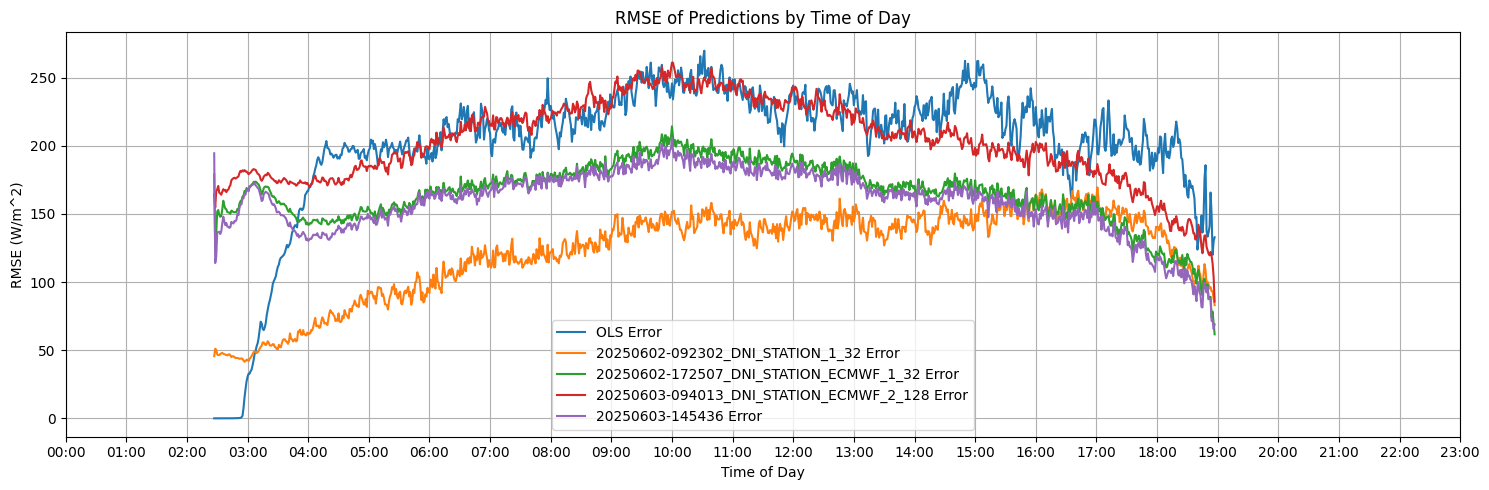

In [11]:
import matplotlib.pyplot as plt
metrics = ForecastEvaluator().evaluate_all(y_true=results.truth[TARGET], y_pred=model_ols_df[OLS_PRED_COLUMN])
fig, ax = plt.subplots(figsize=(15, 5))
for col in error_columns:
    rmse_values = error_comparison_df.groupby('minute_of_day')[col].apply(lambda x: (x**2).mean()**0.5)
    rmse_values.plot(ax=ax, ylabel='RMSE (W/m^2)', xlabel='Time of Day', label=col)
ax.set_xticks(range(0, 1440, 60))  # Every hour
ax.set_xticklabels([f"{i // 60:02d}:{i % 60:02d}" for i in range(0, 1440, 60)], rotation=0)
ax.legend()
plt.title('RMSE of Predictions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('RMSE (W/m^2)')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
from data_loader import MyDataLoader, SPLIT
from my_config import MyConfig, load_config

my_config: MyConfig = load_config(PATH_BASE / 'configs' / 'dni_only' / 'dni_lag1.json')
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=True, drop_nan=True)
model_persistence_lag1_df = data_loader.get_split(SPLIT.TEST)
model_persistence_lag1_df['Error'] = model_persistence_lag1_df[data_loader.get_target_names()[0]] - model_persistence_lag1_df[data_loader.get_feature_names()[0]]
print(f'Min error: {model_persistence_lag1_df["Error"].min()}, Max error: {model_persistence_lag1_df["Error"].max()}')
model_persistence_lag1_df

Min error: -885.72, Max error: 879.8541115702818


,DNI,DNI_lag_1,Error
2024-01-01 07:43:00,0.0,0.0,0.0
2024-01-01 07:44:00,0.0,0.0,0.0
2024-01-01 07:45:00,0.0,0.0,0.0
2024-01-01 07:46:00,0.0,0.0,0.0
2024-01-01 07:47:00,0.0,0.0,0.0
...,...,...,...
2024-12-30 14:38:00,0.0,0.0,0.0
2024-12-30 14:39:00,0.0,0.0,0.0
2024-12-30 14:40:00,0.0,0.0,0.0
2024-12-30 14:41:00,0.0,0.0,0.0


In [ ]:
display(model_persistence_lag1_df)
model_persistence_lag1_df['Error'] = model_persistence_lag1_df[data_loader.get_target_names()[0]] - model_persistence_lag1_df[data_loader.get_feature_names()[0]]
model_persistence_lag1_df['timestamp'] = pd.to_datetime(model_persistence_lag1_df.index)
model_persistence_lag1_df['date'] = model_persistence_lag1_df['timestamp'].dt.date
model_persistence_lag1_df['minute_of_day'] = model_persistence_lag1_df['timestamp'].dt.hour * 60 + model_persistence_lag1_df['timestamp'].dt.minute
display(model_persistence_lag1_df)
import numpy as np
model_persistence_lag1_df['squared_error'] = (model_persistence_lag1_df['Error']) ** 2
rmse_df = (
    model_persistence_lag1_df
    .groupby(['minute_of_day'])['squared_error']
    .mean()
    .reset_index()
)
rmse_df['rmse'] = np.sqrt(rmse_df['squared_error'])
rmse_df = rmse_df.drop(columns='squared_error')
model_persistence_lag1_rmse_df = rmse_df.copy()
model_persistence_lag1_rmse_df

,DNI,DNI_lag_1,Error
2024-01-01 07:43:00,0.0,0.0,0.0
2024-01-01 07:44:00,0.0,0.0,0.0
2024-01-01 07:45:00,0.0,0.0,0.0
2024-01-01 07:46:00,0.0,0.0,0.0
2024-01-01 07:47:00,0.0,0.0,0.0
...,...,...,...
2024-12-30 14:38:00,0.0,0.0,0.0
2024-12-30 14:39:00,0.0,0.0,0.0
2024-12-30 14:40:00,0.0,0.0,0.0
2024-12-30 14:41:00,0.0,0.0,0.0


,DNI,DNI_lag_1,Error,timestamp,date,minute_of_day
2024-01-01 07:43:00,0.0,0.0,0.0,2024-01-01 07:43:00,2024-01-01,463
2024-01-01 07:44:00,0.0,0.0,0.0,2024-01-01 07:44:00,2024-01-01,464
2024-01-01 07:45:00,0.0,0.0,0.0,2024-01-01 07:45:00,2024-01-01,465
2024-01-01 07:46:00,0.0,0.0,0.0,2024-01-01 07:46:00,2024-01-01,466
2024-01-01 07:47:00,0.0,0.0,0.0,2024-01-01 07:47:00,2024-01-01,467
...,...,...,...,...,...,...
2024-12-30 14:38:00,0.0,0.0,0.0,2024-12-30 14:38:00,2024-12-30,878
2024-12-30 14:39:00,0.0,0.0,0.0,2024-12-30 14:39:00,2024-12-30,879
2024-12-30 14:40:00,0.0,0.0,0.0,2024-12-30 14:40:00,2024-12-30,880
2024-12-30 14:41:00,0.0,0.0,0.0,2024-12-30 14:41:00,2024-12-30,881


,minute_of_day,rmse
0,147,0.000000
1,148,0.000000
2,149,0.000000
3,150,0.000000
4,151,0.000000
...,...,...
1045,1192,0.020949
1046,1193,0.008731
1047,1194,0.000000
1048,1195,0.000000


In [ ]:
from data_loader import MyDataLoader, SPLIT
from my_config import MyConfig, load_config

my_config: MyConfig = load_config(PATH_BASE / 'configs' / 'dni_only' / 'dni_lag60.json')
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=True, drop_nan=True)
model_persistence_lag60_df = data_loader.get_split(SPLIT.TEST)
model_persistence_lag60_df['Error'] = model_persistence_lag60_df[data_loader.get_target_names()[0]] - model_persistence_lag60_df[data_loader.get_feature_names()[0]]
print(f'Min error: {model_persistence_lag60_df["Error"].min()}, Max error: {model_persistence_lag60_df["Error"].max()}')
display(model_persistence_lag60_df)
model_persistence_lag60_df['Error'] = model_persistence_lag60_df[data_loader.get_target_names()[0]] - model_persistence_lag60_df[data_loader.get_feature_names()[0]]
model_persistence_lag60_df['timestamp'] = pd.to_datetime(model_persistence_lag60_df.index)
model_persistence_lag60_df['date'] = model_persistence_lag60_df['timestamp'].dt.date
model_persistence_lag60_df['minute_of_day'] = model_persistence_lag60_df['timestamp'].dt.hour * 60 + model_persistence_lag60_df['timestamp'].dt.minute
display(model_persistence_lag60_df)
import numpy as np
model_persistence_lag60_df['squared_error'] = (model_persistence_lag60_df['Error']) ** 2
rmse_df = (
    model_persistence_lag60_df
    .groupby(['minute_of_day'])['squared_error']
    .mean()
    .reset_index()
)
rmse_df['rmse'] = np.sqrt(rmse_df['squared_error'])
rmse_df = rmse_df.drop(columns='squared_error')
model_persistence_lag60_rmse_df = rmse_df.copy()
model_persistence_lag60_rmse_df

Min error: -966.6108445600717, Max error: 950.3229165725099


,DNI,DNI_lag_60,Error
2024-01-01 07:43:00,0.0,0.0,0.0
2024-01-01 07:44:00,0.0,0.0,0.0
2024-01-01 07:45:00,0.0,0.0,0.0
2024-01-01 07:46:00,0.0,0.0,0.0
2024-01-01 07:47:00,0.0,0.0,0.0
...,...,...,...
2024-12-30 14:38:00,0.0,0.0,0.0
2024-12-30 14:39:00,0.0,0.0,0.0
2024-12-30 14:40:00,0.0,0.0,0.0
2024-12-30 14:41:00,0.0,0.0,0.0


,DNI,DNI_lag_60,Error,timestamp,date,minute_of_day
2024-01-01 07:43:00,0.0,0.0,0.0,2024-01-01 07:43:00,2024-01-01,463
2024-01-01 07:44:00,0.0,0.0,0.0,2024-01-01 07:44:00,2024-01-01,464
2024-01-01 07:45:00,0.0,0.0,0.0,2024-01-01 07:45:00,2024-01-01,465
2024-01-01 07:46:00,0.0,0.0,0.0,2024-01-01 07:46:00,2024-01-01,466
2024-01-01 07:47:00,0.0,0.0,0.0,2024-01-01 07:47:00,2024-01-01,467
...,...,...,...,...,...,...
2024-12-30 14:38:00,0.0,0.0,0.0,2024-12-30 14:38:00,2024-12-30,878
2024-12-30 14:39:00,0.0,0.0,0.0,2024-12-30 14:39:00,2024-12-30,879
2024-12-30 14:40:00,0.0,0.0,0.0,2024-12-30 14:40:00,2024-12-30,880
2024-12-30 14:41:00,0.0,0.0,0.0,2024-12-30 14:41:00,2024-12-30,881


,minute_of_day,rmse
0,147,0.000000
1,148,0.000000
2,149,0.000000
3,150,0.000000
4,151,0.000000
...,...,...
1045,1192,251.427902
1046,1193,238.788819
1047,1194,253.130129
1048,1195,240.272695


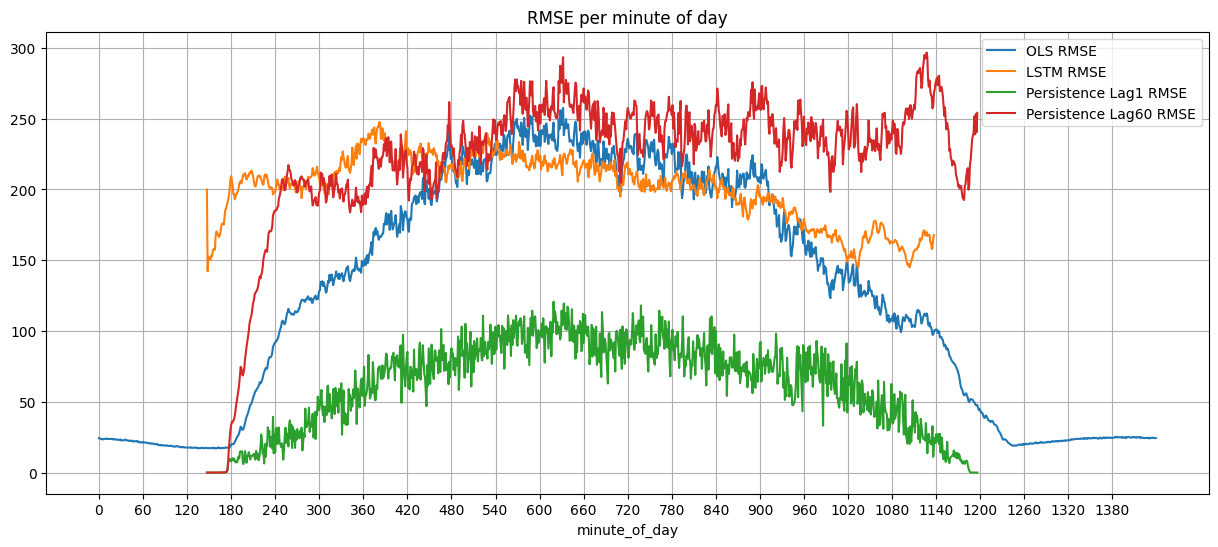

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 6))
model_ols_rmse_df.plot(x='minute_of_day', y='rmse', figsize=(15, 6), title='RMSE per minute of day', grid=True, ax=ax, label='OLS RMSE')
model_lstm_rmse_df.plot(x='minute_of_day', y='rmse', figsize=(15, 6), title='RMSE per minute of day', grid=True, ax=ax, label='LSTM RMSE')
model_persistence_lag1_rmse_df.plot(x='minute_of_day', y='rmse', figsize=(15, 6), title='RMSE per minute of day', grid=True, ax=ax, label='Persistence Lag1 RMSE')
model_persistence_lag60_rmse_df.plot(x='minute_of_day', y='rmse', figsize=(15, 6), title='RMSE per minute of day', grid=True, ax=ax, label='Persistence Lag60 RMSE')
# set x axis to human readable time format
ax.set_xticks(range(0, 1440, 60))  # Every hour

C:\Users\lucas\AppData\Local\Temp\ipykernel_4208\715976228.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  minute_600_data.hist(bins=30, alpha=0.6, ax=ax)
C:\Users\lucas\AppData\Local\Temp\ipykernel_4208\715976228.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


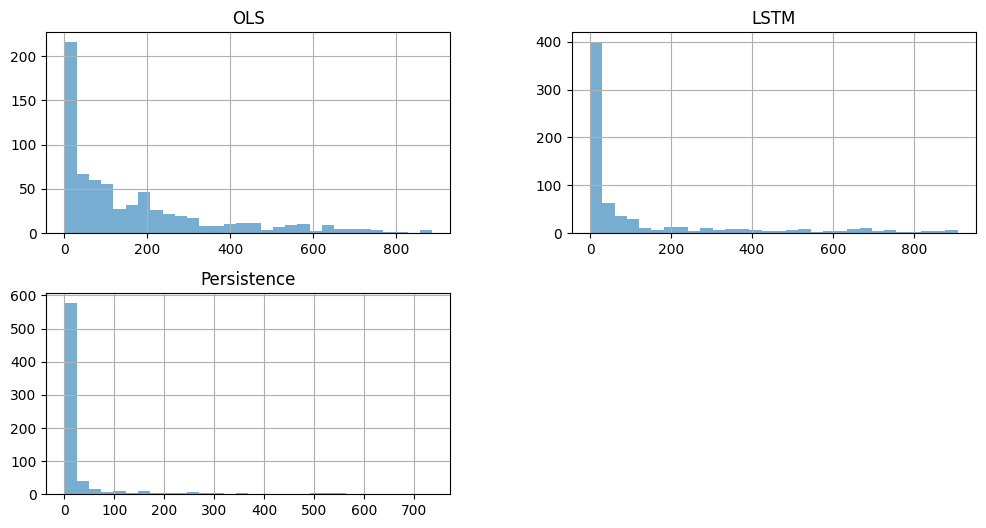

In [ ]:
minute_600_data = pd.DataFrame({
    'OLS': abs(model_ols_df[model_ols_df['minute_of_day'] == 600]['Error']),
    'LSTM': abs(model_lstm_df[model_lstm_df['minute_of_day'] == 600]['Error']),
    'Persistence': abs(model_persistence_lag1_df[model_persistence_lag1_df['minute_of_day'] == 600]['Error'])
})

fig, ax = plt.subplots(figsize=(12, 6))
minute_600_data.hist(bins=30, alpha=0.6, ax=ax)
plt.title('Distribution of Absolute Errors at Minute 600 (10:00 AM)')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()


# Summary Statistics for Absolute Errors at Minute 600

In [ ]:
# stats_df = pd.DataFrame({
#     'Model': ['OLS', 'LSTM', 'Persistence'],
#     'Mean': [
#         selected_time_df_ols.mean(),
#         selected_time_df_lstm.mean(),
#         selected_time_df_persistence.mean()
#     ],
#     'Median': [
#         selected_time_df_ols.median(),
#         selected_time_df_lstm.median(),
#         selected_time_df_persistence.median()
#     ]
# })
#
# display(stats_df)


In [ ]:
model_ols_df

,Actual,Predicted,Error,timestamp,date,minute_of_day,squared_error
2023-01-01 08:43:00,0.004765,1.937249,-1.932484,2023-01-01 08:43:00,2023-01-01,523,3.734494
2023-01-01 08:44:00,0.000000,2.087521,-2.087521,2023-01-01 08:44:00,2023-01-01,524,4.357743
2023-01-01 08:45:00,0.000000,2.757329,-2.757329,2023-01-01 08:45:00,2023-01-01,525,7.602866
2023-01-01 08:46:00,0.000000,2.400412,-2.400412,2023-01-01 08:46:00,2023-01-01,526,5.761978
2023-01-01 08:47:00,0.000000,2.288358,-2.288358,2023-01-01 08:47:00,2023-01-01,527,5.236582
...,...,...,...,...,...,...,...
2024-12-30 14:36:00,0.000000,0.000000,0.000000,2024-12-30 14:36:00,2024-12-30,876,0.000000
2024-12-30 14:37:00,0.000000,0.000000,0.000000,2024-12-30 14:37:00,2024-12-30,877,0.000000
2024-12-30 14:38:00,0.000000,0.000000,0.000000,2024-12-30 14:38:00,2024-12-30,878,0.000000
2024-12-30 14:39:00,0.000000,0.000000,0.000000,2024-12-30 14:39:00,2024-12-30,879,0.000000


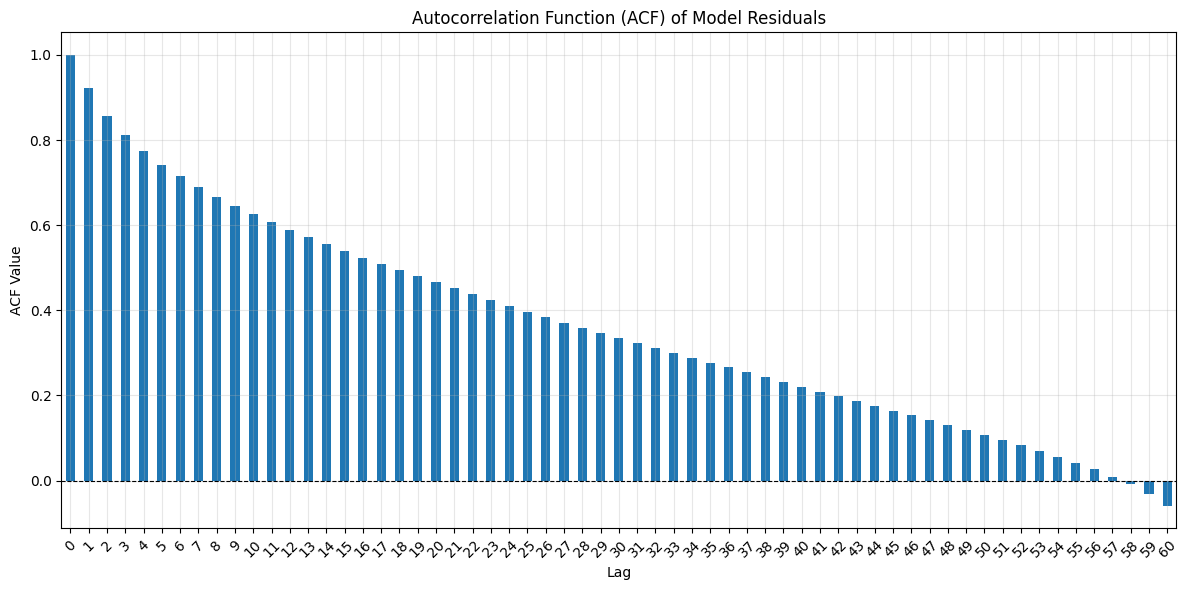

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

# Compute residuals using the correct column names
df = model_lstm_df.copy()
df['residual'] = df['Error']

# Compute autocorrelation values for the residuals up to lag 20
from statsmodels.tsa.stattools import acf
acf_values = acf(df['residual'], nlags=60, fft=True)
lags = list(range(len(acf_values)))
acf_df = pd.DataFrame({'lag': lags, 'acf': acf_values})
# plot ACF values
fig, ax = plt.subplots(figsize=(12, 6))
acf_df.plot(x='lag', y='acf', kind='bar', ax=ax, legend=False)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.set_title('Autocorrelation Function (ACF) of Model Residuals')
ax.set_xlabel('Lag')
ax.set_ylabel('ACF Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
model_ols_df

,Actual,Predicted,Error,timestamp,date,minute_of_day,squared_error
2023-01-01 08:43:00,0.004765,1.937249,-1.932484,2023-01-01 08:43:00,2023-01-01,523,3.734494
2023-01-01 08:44:00,0.000000,2.087521,-2.087521,2023-01-01 08:44:00,2023-01-01,524,4.357743
2023-01-01 08:45:00,0.000000,2.757329,-2.757329,2023-01-01 08:45:00,2023-01-01,525,7.602866
2023-01-01 08:46:00,0.000000,2.400412,-2.400412,2023-01-01 08:46:00,2023-01-01,526,5.761978
2023-01-01 08:47:00,0.000000,2.288358,-2.288358,2023-01-01 08:47:00,2023-01-01,527,5.236582
...,...,...,...,...,...,...,...
2024-12-30 14:36:00,0.000000,0.000000,0.000000,2024-12-30 14:36:00,2024-12-30,876,0.000000
2024-12-30 14:37:00,0.000000,0.000000,0.000000,2024-12-30 14:37:00,2024-12-30,877,0.000000
2024-12-30 14:38:00,0.000000,0.000000,0.000000,2024-12-30 14:38:00,2024-12-30,878,0.000000
2024-12-30 14:39:00,0.000000,0.000000,0.000000,2024-12-30 14:39:00,2024-12-30,879,0.000000


<Axes: >

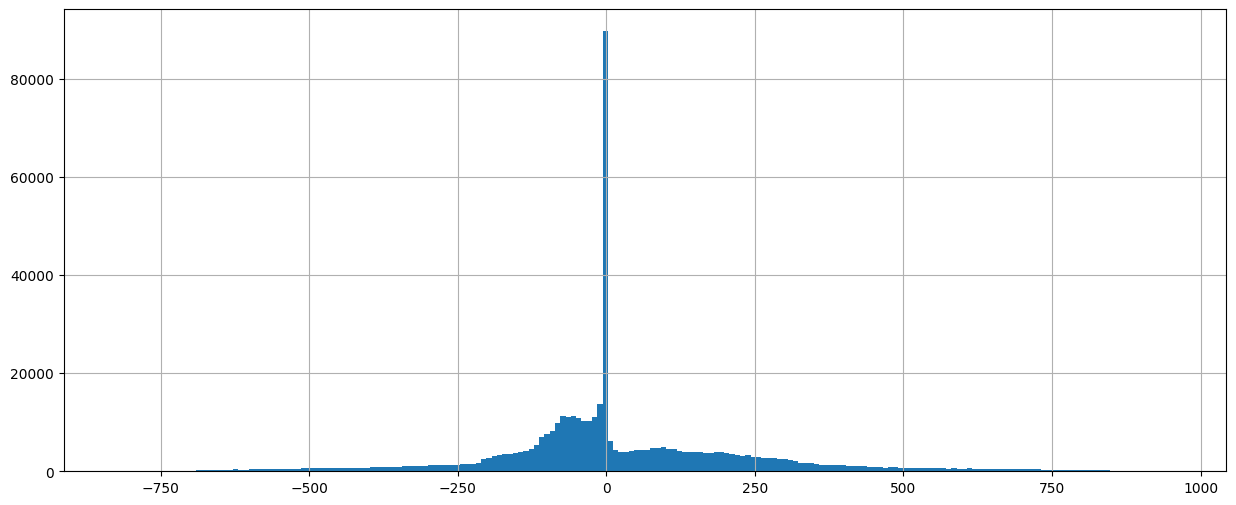

In [ ]:
fig = plt.figure(figsize=(15, 6))
model_ols_df['Error'].hist(bins=200)


<Axes: >

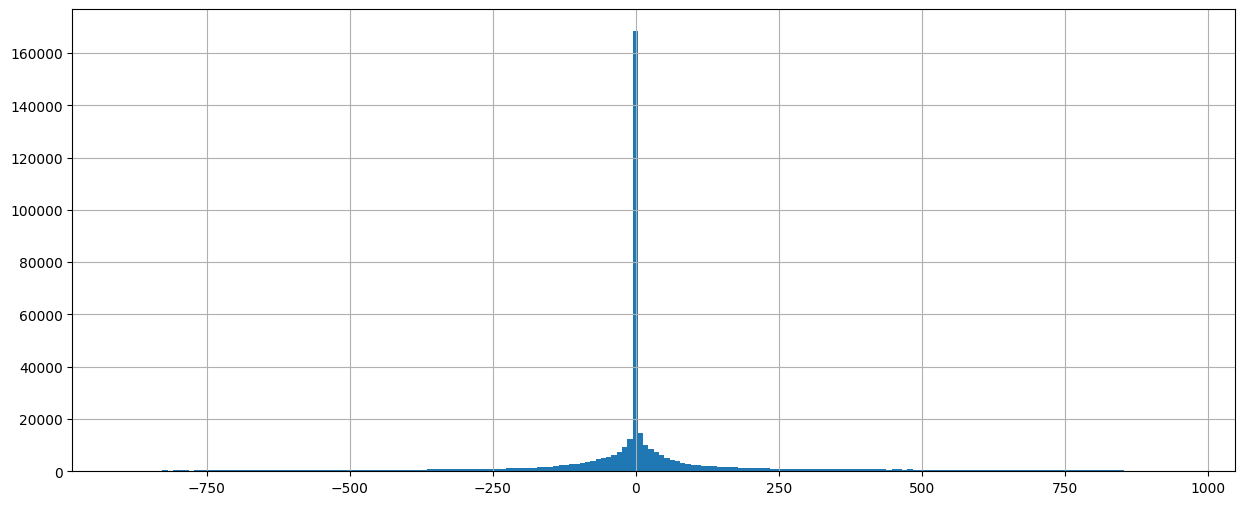

In [ ]:
fig = plt.figure(figsize=(15, 6))
model_lstm_df['Error'].hist(bins=200)

<Axes: >

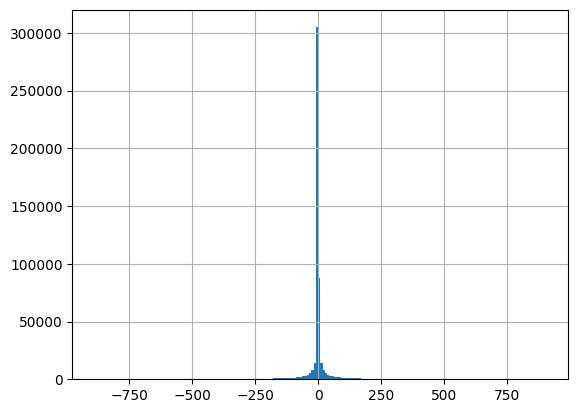

In [ ]:
model_persistence_lag1_df['Error'].hist(bins=200)